[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zora-no/iannwtf/blob/main/hw-week08/hw_week08_group27.ipynb)
# Homework 08 — IANNwTF
## Group 27
Deadline: Dec 19, 2021 23:59

<https://forms.gle/n6ERdhYx3uBPzuGn9>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 15

# Dataset



In [ ]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data(as_supervised=True)

In [ ]:
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


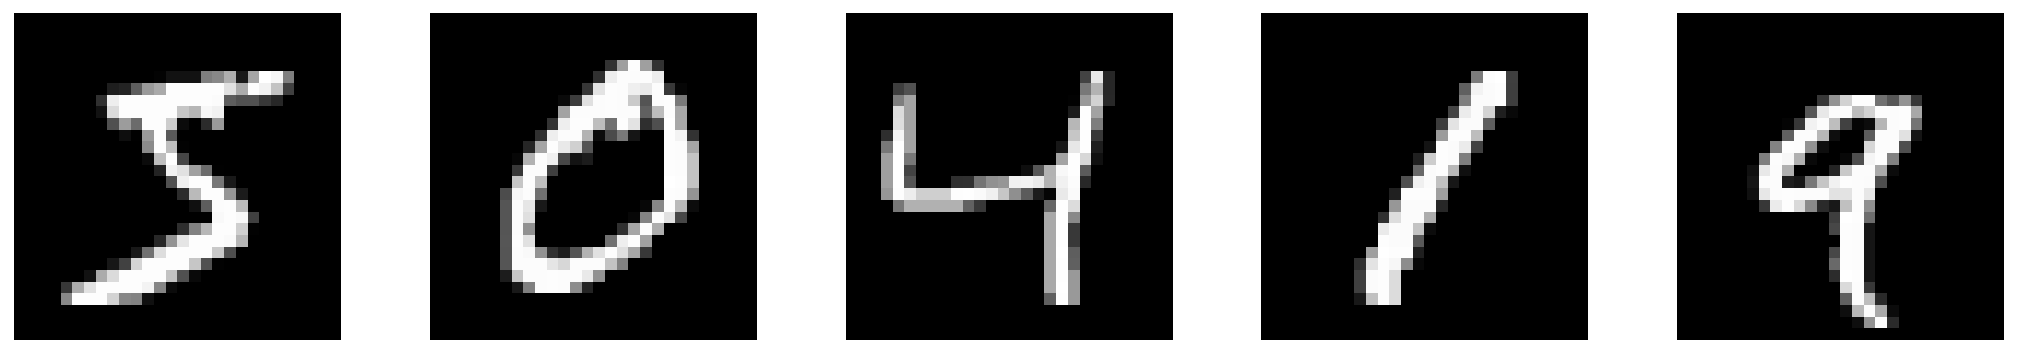

In [ ]:
npics = 5
fig, ax = plt.subplots(nrows=1, ncols=npics, figsize=(18,3))
ax = ax.ravel()
for i in range(npics):
  ax[i].imshow(X_train[i], cmap='gray')
  ax[i].axis("off")

In [ ]:
# Load the dataset and construct a tf.Data.Dateset for testing and training using the images only
train_ds = tf.data.Dataset.from_tensor_slices(X_train)
test_ds = tf.data.Dataset.from_tensor_slices(X_test)

In [ ]:
def prepare_data(ds, target_ds=False):
    # convert data from uint8 to float32
    ds = ds.map(lambda img: (tf.cast(img, tf.float32)))
    
    # bring image values from range [0, 255] to [0, 1]
    ds = ds.map(lambda img: (img/255.))
    
    # add third dimension
    ds = ds.map(lambda img: tf.expand_dims(img, axis=-1))
    
    if target_ds == False:
        # Add noise to the images
        how_noisy = 0.2 # std deviation of the normal distribution
        
        ds = ds.map(lambda img: tf.add(img, tf.random.normal(shape=(28,28,1), mean=0.0, stddev=how_noisy, dtype=tf.dtypes.float32)))

    # make sure the images are kept in the range [0,1]
    ds = ds.map(lambda img: tf.clip_by_value(img, 0, 1))
    # shuffle, batch, prefetch
    ds = ds.shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
train_inputs_ds = prepare_data(train_ds)
test_inputs_ds = prepare_data(test_ds)
train_targets_ds = prepare_data(train_ds, target_ds=True)
test_targets_ds = prepare_data(test_ds, target_ds=True)

(64, 28, 28, 1) (64, 28, 28, 1)


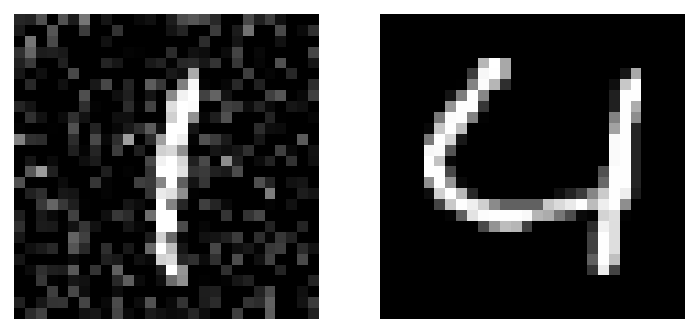

In [ ]:
# I don't think this will work
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = ax.ravel()
for inputs, targets in zip(train_inputs_ds, train_targets_ds):
    print(inputs.shape, targets.shape)
    ax[0].imshow(tf.squeeze(inputs).numpy()[0], cmap='gray')
    ax[0].axis("off")
    ax[1].imshow(tf.squeeze(targets).numpy()[0], cmap='gray')
    ax[1].axis("off")
    break

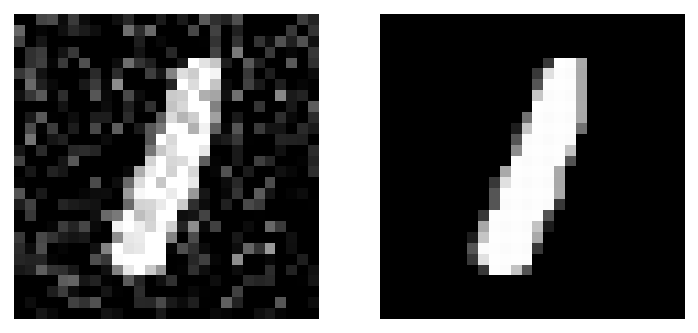

In [22]:
# This will work though

import tensorflow_datasets as tfds

train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

def add_noise(img, noise_amount=0.2):

    noise = tf.random.normal(shape=img.shape, mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)

    img = img + noise * noise_amount
    
    img = tf.clip_by_value(img, 0, 1)

    return img

def prepare_data(mnist):
    # convert data from uint8 to float32
    mnist = mnist.map(lambda img, label: (tf.cast(img, tf.float32), label))
    
    # bring image values from range [0, 255] to [0, 1]
    mnist = mnist.map(lambda img, label: (img/255., label))
    
    # add third dimension
    mnist = mnist.map(lambda img, label: (tf.expand_dims(img, axis=-1), label))
        
    mnist =  mnist.map(lambda img, label: (add_noise(img), img, label))

    # shuffle, batch, prefetch
    mnist = mnist.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
    return mnist

train_ds = prepare_data(train_ds)
test_ds = prepare_data(test_ds)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = ax.ravel()
for inputs, targets, _ in train_ds:
    ax[0].imshow(tf.squeeze(inputs).numpy()[0], cmap='gray')
    ax[0].axis("off")
    ax[1].imshow(tf.squeeze(targets).numpy()[0], cmap='gray')
    ax[1].axis("off")
    break

# Model: Convolutional Autoencoder

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_size=10):
        super(Encoder, self).__init__()
        
        self.all_teh_layers = [tf.keras.layers.Conv2D(filters=64,
                                               kernel_size=3,
                                               strides=2,
                                               padding="same",
                                               activation='relu',
                                               input_shape=((28,28,1))),
                        tf.keras.layers.Conv2D(filters=128,
                                               kernel_size=3,
                                               strides=2,
                                               padding="same",
                                               activation='relu'),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(embedding_size,activation='relu')
                              ]
        
    def call(self, x, training=True):
        for layer in self.all_teh_layers:
            x = layer(x, training = training)
        return x


In [18]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.all_teh_layers = [
            tf.keras.layers.Dense(units=3136,
                              activation='relu'),
            tf.keras.layers.Reshape((7, 7, 64)),
            tf.keras.layers.Conv2DTranspose(filters=128,
                                            kernel_size=3,
                                            strides=2,
                                            padding='same',
                                            activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=64,
                                            kernel_size=3,
                                            strides=2,
                                            padding='same',
                                            activation='relu'),
            tf.keras.layers.Conv2D(filters=1,
                                   kernel_size=3,
                                   strides=1,
                                   padding='same',
                                   activation='sigmoid')
    ]
  
    def call(self, x, training=True):
        for layer in self.all_teh_layers:
            x = layer(x, training = training)
        return x  

In [19]:
class Autoencoder(tf.keras.Model):
    
    def __init__(self, embedding_size=10):
        
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(embedding_size=embedding_size)
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

# Training

In [20]:
@tf.function
def train_step(model, inputs, targets, loss_fn, optimizer, loss_metric):
    # training step
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    logs = {}
    loss_metric.update_state(loss)
    logs["loss"] = loss_metric.result()
    return logs
    
@tf.function
def test_step(inputs, targets, loss_fn, loss_metric):
    # test step
    predictions = model(inputs)
    loss = loss_fn(targets, predictions)
    logs = {}
    loss_metric.update_state(loss)
    logs["val_loss"] = loss_metric.result()
    return logs, predictions

In [21]:
tf.keras.backend.clear_session()

# Hyperparameters
epochs = 10
learning_rate = 0.001

# Initialize the model
model = Autoencoder(embedding_size=10)

# Initialize the loss function (MSE)
loss_fn = tf.keras.losses.MeanSquaredError()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad = True)

# Metrics
loss_metric = tf.keras.metrics.Mean()
hist = {'loss': [], 'val_loss': []}


def reset_metrics(metrics):
    # utility function to reset the state of metrics
    for metric in metrics:
        metric.reset_state()

examples = {"prediction": [], "target": []}

# training
for epoch in range(epochs):
    reset_metrics([loss_metric])
    for inputs, targets, _ in train_ds:
        logs = train_step(model, inputs, targets, loss_fn, optimizer, loss_metric)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")

    # test
    reset_metrics([loss_metric])
    for inputs, targets, _ in test_ds:
        logs, predictions = test_step(inputs, targets, loss_fn, loss_metric)
    id = np.random.randint(12)
    examples["prediction"].append(predictions[id])
    examples["target"].append(targets[id])
    print("...Evaluation results:")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")
    print("\n")

Results at the end of epoch 0
...loss: 0.0413
...Evaluation results:
...val_loss: 0.0259


Results at the end of epoch 1
...loss: 0.0247
...Evaluation results:
...val_loss: 0.0234


Results at the end of epoch 2
...loss: 0.0232
...Evaluation results:
...val_loss: 0.0230


Results at the end of epoch 3
...loss: 0.0224
...Evaluation results:
...val_loss: 0.0221


Results at the end of epoch 4
...loss: 0.0219
...Evaluation results:
...val_loss: 0.0216


Results at the end of epoch 5
...loss: 0.0215
...Evaluation results:
...val_loss: 0.0214


Results at the end of epoch 6
...loss: 0.0211
...Evaluation results:
...val_loss: 0.0208


Results at the end of epoch 7
...loss: 0.0209
...Evaluation results:
...val_loss: 0.0208


Results at the end of epoch 8
...loss: 0.0207
...Evaluation results:
...val_loss: 0.0207


Results at the end of epoch 9
...loss: 0.0205
...Evaluation results:
...val_loss: 0.0204




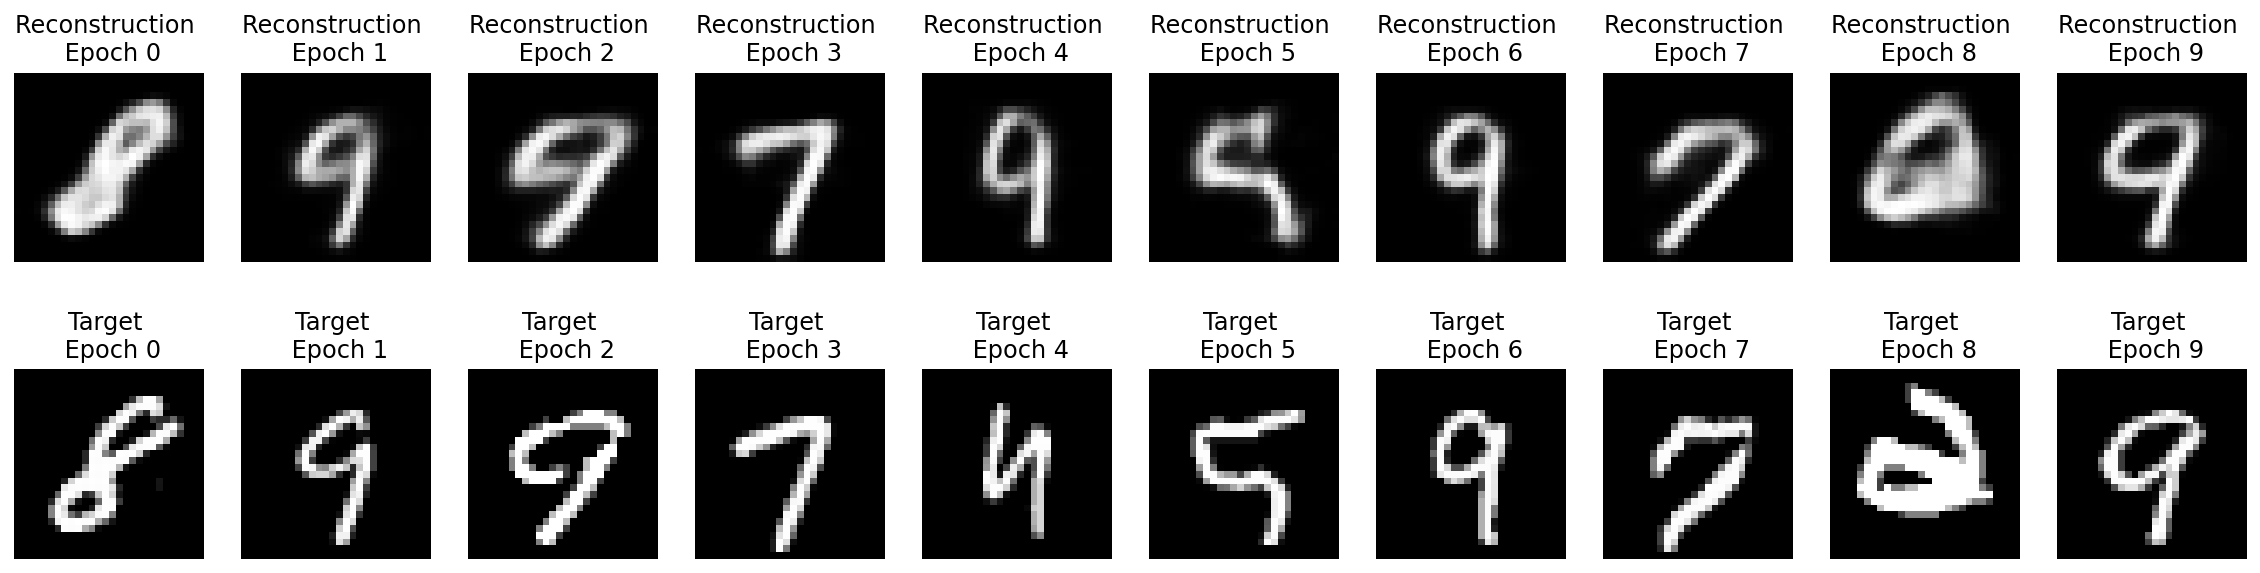

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=epochs, figsize=(20,5))
ax = ax.ravel()
for i, prediction in enumerate(examples["prediction"]):
    ax[i].imshow(tf.squeeze(prediction).numpy(), cmap='gray')
    ax[i].set_title(f"Reconstruction \n Epoch {i}")  
    ax[i].axis("off")

for i, target in enumerate(examples["target"]):
    ax[epochs+i].imshow(tf.squeeze(target).numpy(), cmap='gray')
    ax[epochs+i].set_title(f"Target \n Epoch {i}")  
    ax[epochs+i].axis("off")

# Latent Space Analysis
# 🌚